# Connective fields in prfpy 

Implementation of connective fields that also use visual space and limits V1 subsurface verts
depending on their eccentricity from previous pRF analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cortex
from prfpy.utils import subsurface
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
import pandas as pd
from scipy.spatial.distance import squareform
import nibabel as nib
import numpy as np
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
import matplotlib.pyplot as plt

/tank/klundert/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/tank/klundert/.local/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [4]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

## load data

In [99]:
np.nan_to_num(s2_f) == np.nan_to_num(np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy"))


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [183]:
s2_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy")
s2_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full_zsc.npy")

In [132]:
s2_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")

In [184]:
mydat_train = np.nan_to_num(get_cortex(s2_f)[:,10:])
mydat_test = np.nan_to_num(get_cortex(s2_f2)[:,10:])

In [185]:
# load design matrix of pRF experiment. We use this to determine max eccentricity

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

print(max_ecc_size)

8.91243496952274


## create subsurface

In [186]:
roi_verts = cortex.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


### modify the subsurface to only include vertices that 'see' the stimuli

In [187]:
prf_params = get_cortex(np.load('/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/dn-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy'))

In [188]:
prf_params.shape

(118584, 10)

In [189]:
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])

Text(0.5, 0.98, 'V1 vertices that we sample')

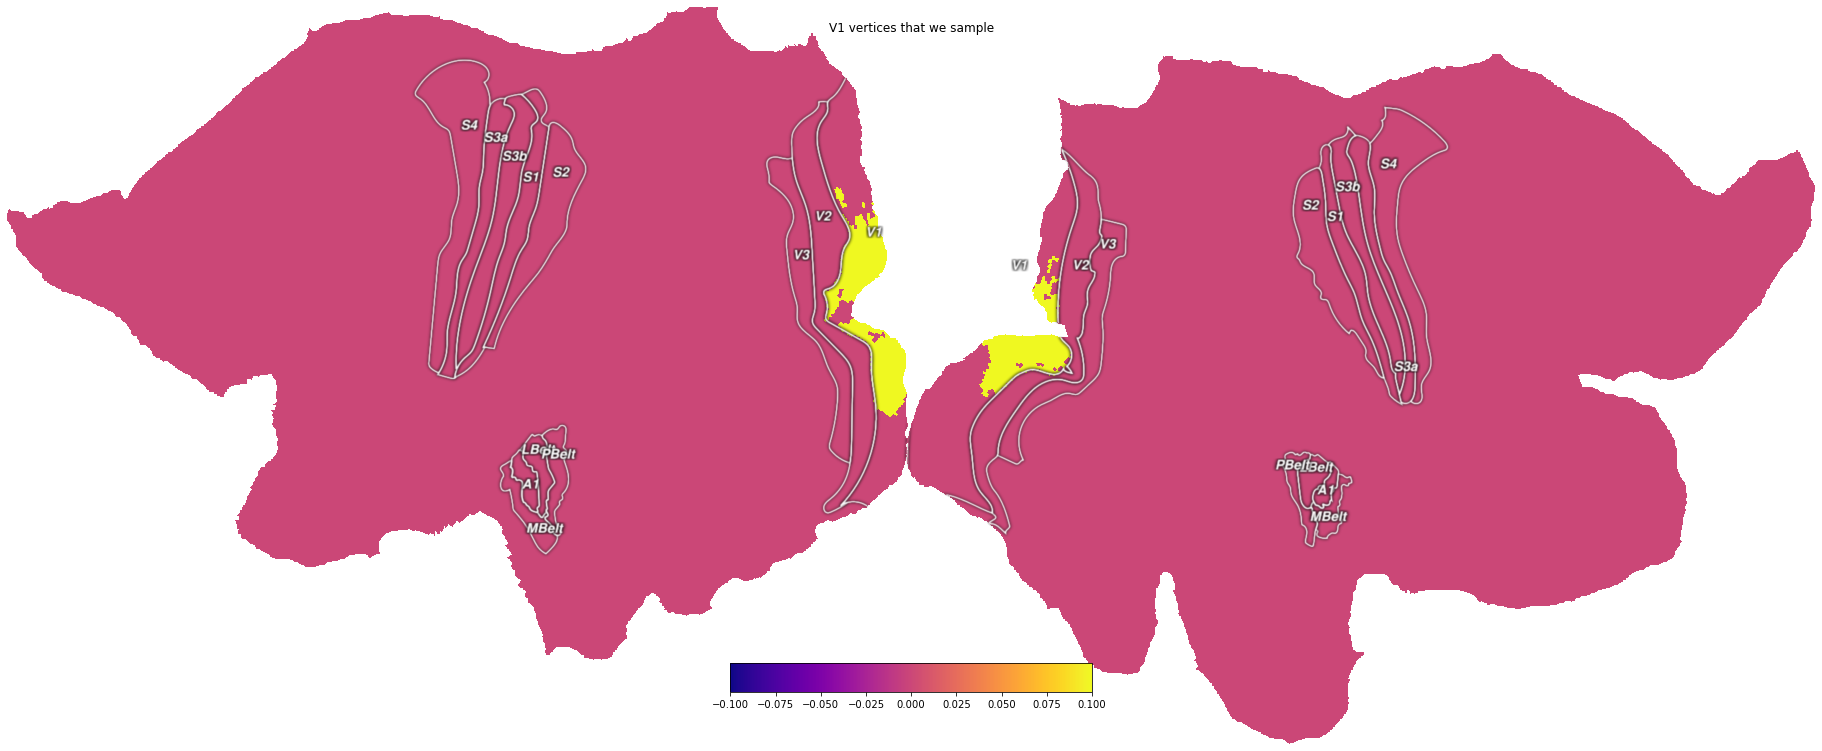

In [190]:
# create eccentricity mask and combine with Rsq and V1 mask

eccMask = gfn_ecc < max_ecc_size
maskLecc, maskRecc = splitList(eccMask)

Rsqmask = prf_params[:,-1] > 0.4
rsqL, rsqR = splitList(Rsqmask)

V1mask = np.concatenate([maskL, maskR])

maskLecc = maskLecc*rsqL
maskRecc = maskRecc*rsqR
intmask = np.concatenate([maskLecc, maskRecc])
intmask = intmask * V1mask

distmaskL = maskLecc[maskL]
distmaskR = maskRecc[maskR]

f = cortex.quickshow(cortex.Vertex(intmask.astype(int), subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('V1 vertices that we sample')

In [191]:
# modify the subsurface distances to only include the vertices we want sample from
# and modify the subsurface_verts to correspond to these vertices we want to sample

myv1surf.dists_R = myv1surf.dists_R[distmaskR][:,distmaskR]
myv1surf.dists_L = myv1surf.dists_L[distmaskL][:,distmaskL]
myv1surf.pad_distance_matrices()
myv1surf.subsurface_verts=np.concatenate([myv1surf.subsurface_verts_L[distmaskL],myv1surf.subsurface_verts_R[distmaskR]])

In [192]:
# these should be size (N,) and (N, N)
print(myv1surf.subsurface_verts.shape)
print(myv1surf.distance_matrix.shape)

(933,)
(933, 933)


### do the fitting in cortical space

In [193]:
# Make stimuli for training and test data
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,myv1surf.distance_matrix)
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,myv1surf.distance_matrix)

# Make a model
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40])

# Define the fitter
gf = CFFitter(data=mydat_train,model=model)
gf.n_jobs = 20
# Perform the fitting.
gf.quick_grid_fit(sigmas)

# Perform the cross validation.
gf.quick_xval(test_data=mydat_test,test_stimulus=test_stim)

/tank/klundert/downloads/prfpy/prfpy/utils.py:139: RuntimeWarning: invalid value encountered in sign
  vec2=(vec**2)*np.sign(vec)


Text(0.5, 0.98, 'CV R2 of quick gridfit CF cortical space')

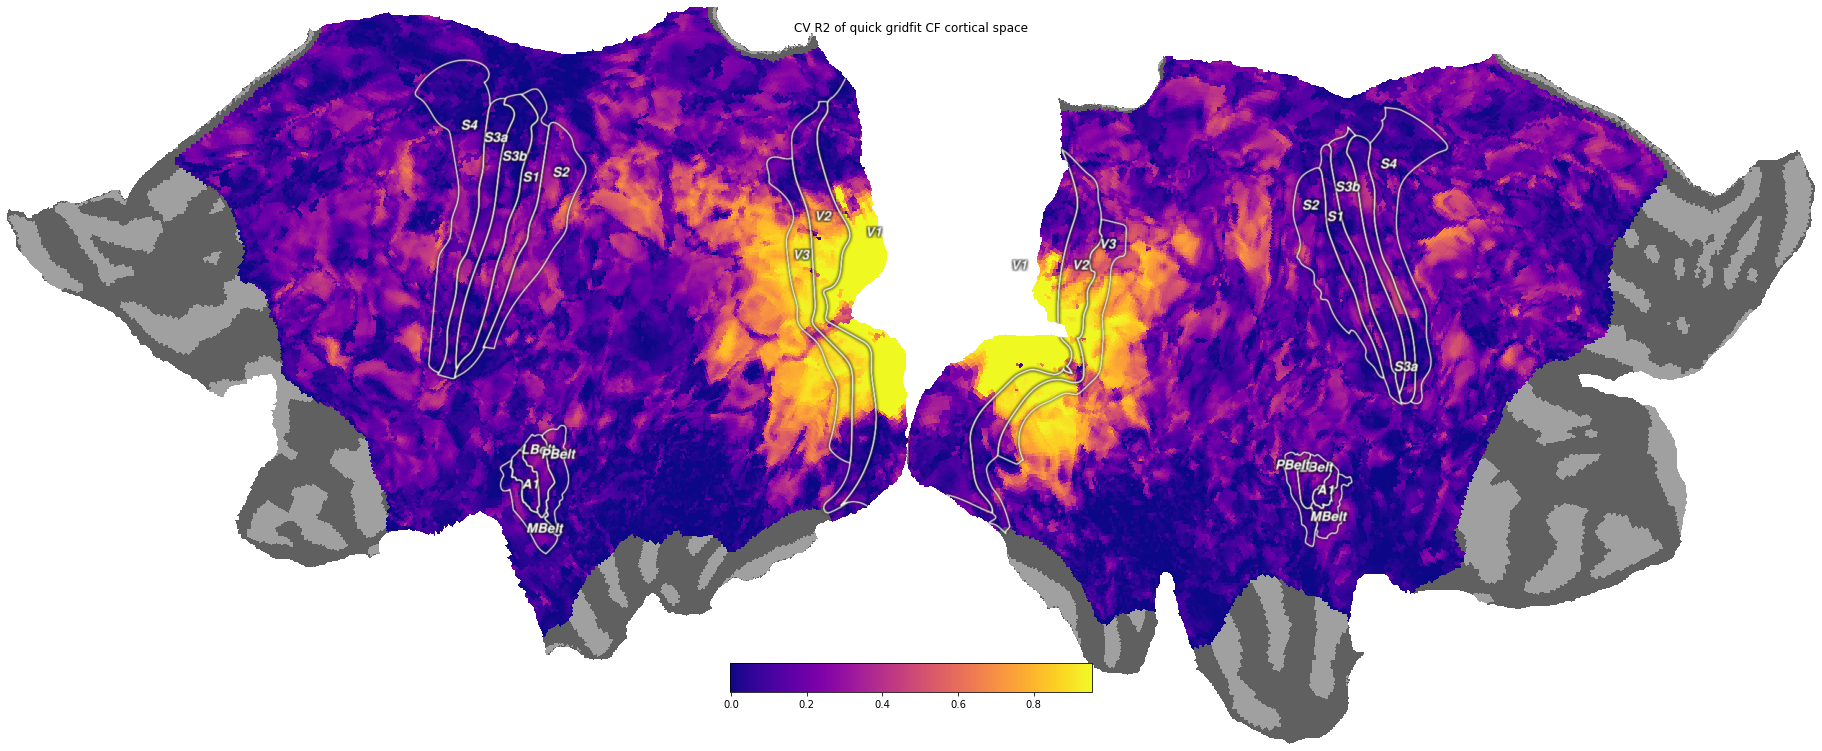

In [179]:
f = cortex.quickshow(cortex.Vertex(gf.xval_R2, subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('CV R2 of quick gridfit CF cortical space')

### now do the fitting in visual space

In [194]:
# set up the distance matrix to correspond to visual space

# create a dataframe that has the x and y pRF parameters per subsurface vert we sample
d2 = {'x': prf_params[:,0], 'y': prf_params[:,1]}
xy_frame = pd.DataFrame(data=d2)

spliced_lookup_xy=xy_frame.iloc[myv1surf.subsurface_verts.astype(int),:]

spliced_lookup_xy

x         y
42059   3.028565 -1.512078
42060   2.943033 -0.871813
42061   2.737934 -0.398551
42062   2.698190 -1.368562
42063   2.681819 -2.245040
...          ...       ...
104873 -3.308182  7.616886
104939 -2.625402  7.392761
105004 -2.346408  7.689249
105069 -2.761097  7.907631
105070 -3.191181  7.041754

[933 rows x 2 columns]

In [195]:
from sklearn.metrics.pairwise import euclidean_distances
visual_distance_matrix = euclidean_distances(spliced_lookup_xy)
visual_distance_matrix

array([[ 0.        ,  0.64595309,  1.15083001, ..., 10.65620739,
        11.05672212, 10.57607161],
       [ 0.64595309,  0.        ,  0.51579319, ..., 10.06329797,
        10.46975314, 10.01264837],
       [ 1.15083001,  0.51579319,  0.        , ...,  9.55316903,
         9.96152573,  9.51380812],
       ...,
       [10.65620739, 10.06329797,  9.55316903, ...,  0.        ,
         0.46867604,  1.06437302],
       [11.05672212, 10.46975314,  9.96152573, ...,  0.46867604,
         0.        ,  0.96680661],
       [10.57607161, 10.01264837,  9.51380812, ...,  1.06437302,
         0.96680661,  0.        ]])

In [196]:
# Make stimuli for training and test data
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,visual_distance_matrix)
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,visual_distance_matrix)

# Make a model
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 20
# Perform the fitting.
gf_vis.quick_grid_fit(sigmas)

# Perform the cross validation.
gf_vis.quick_xval(test_data=mydat_test,test_stimulus=test_stim)

/tank/klundert/downloads/prfpy/prfpy/utils.py:139: RuntimeWarning: invalid value encountered in sign
  vec2=(vec**2)*np.sign(vec)


Text(0.5, 0.98, 'CV R2 of quick gridfit CF visual space')

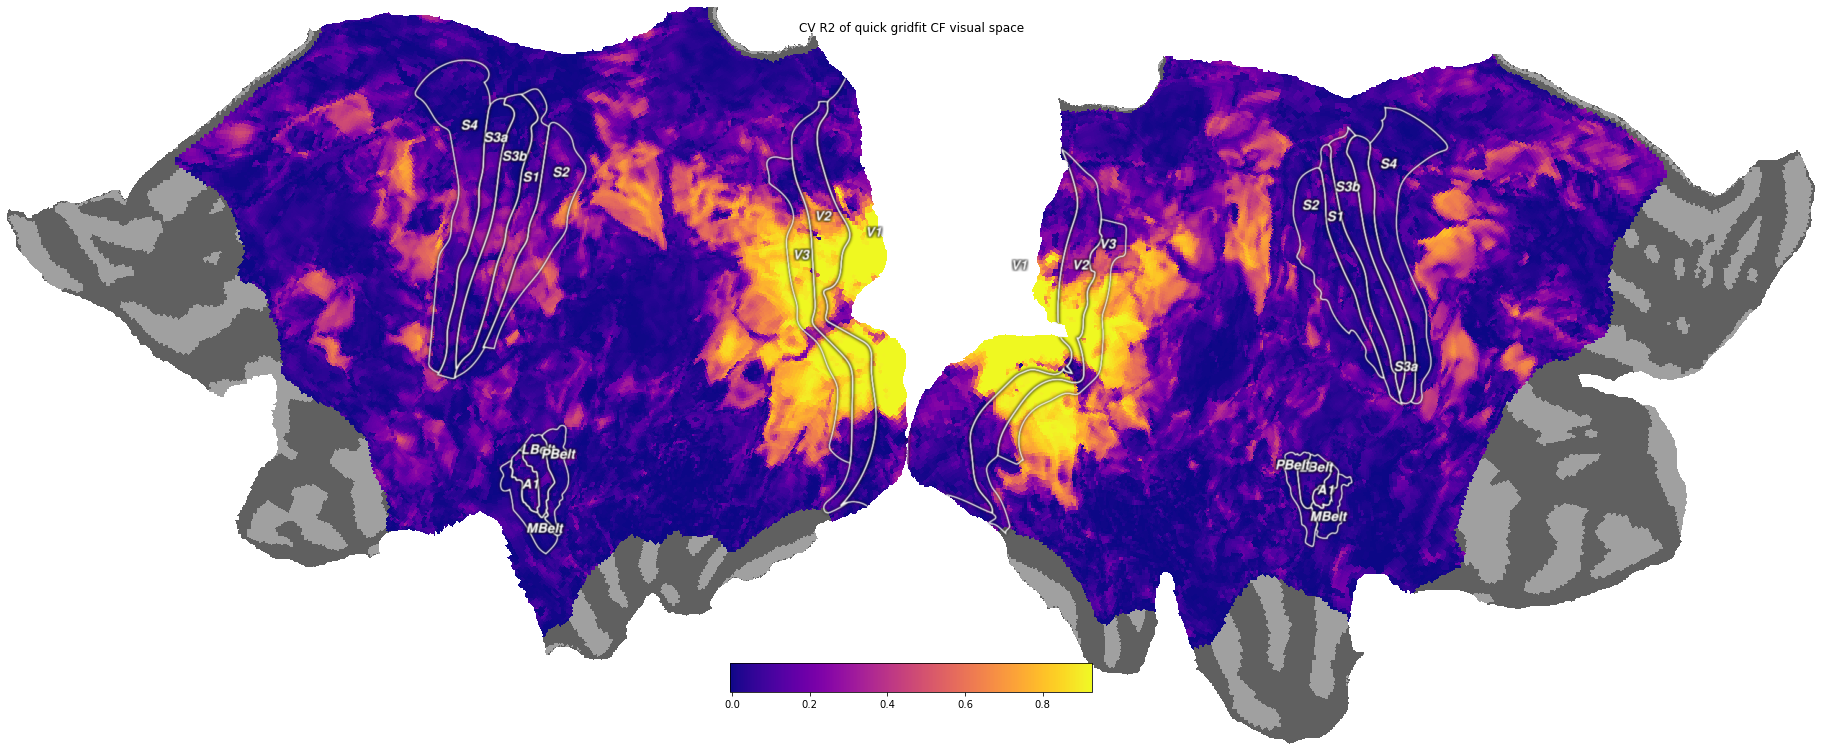

In [180]:
f = cortex.quickshow(cortex.Vertex(gf_vis.xval_R2, subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('CV R2 of quick gridfit CF visual space')

In [182]:
# psc_R2_cortical = np.copy(gf.xval_R2)
# psc_R2_visual = np.copy(gf_vis.xval_R2)

In [197]:
diff1 = psc_R2_cortical - gf.xval_R2
diff2 = psc_R2_visual - gf_vis.xval_R2

### compare them

Text(0.5, 0.98, 'psc-zsc cortical space')

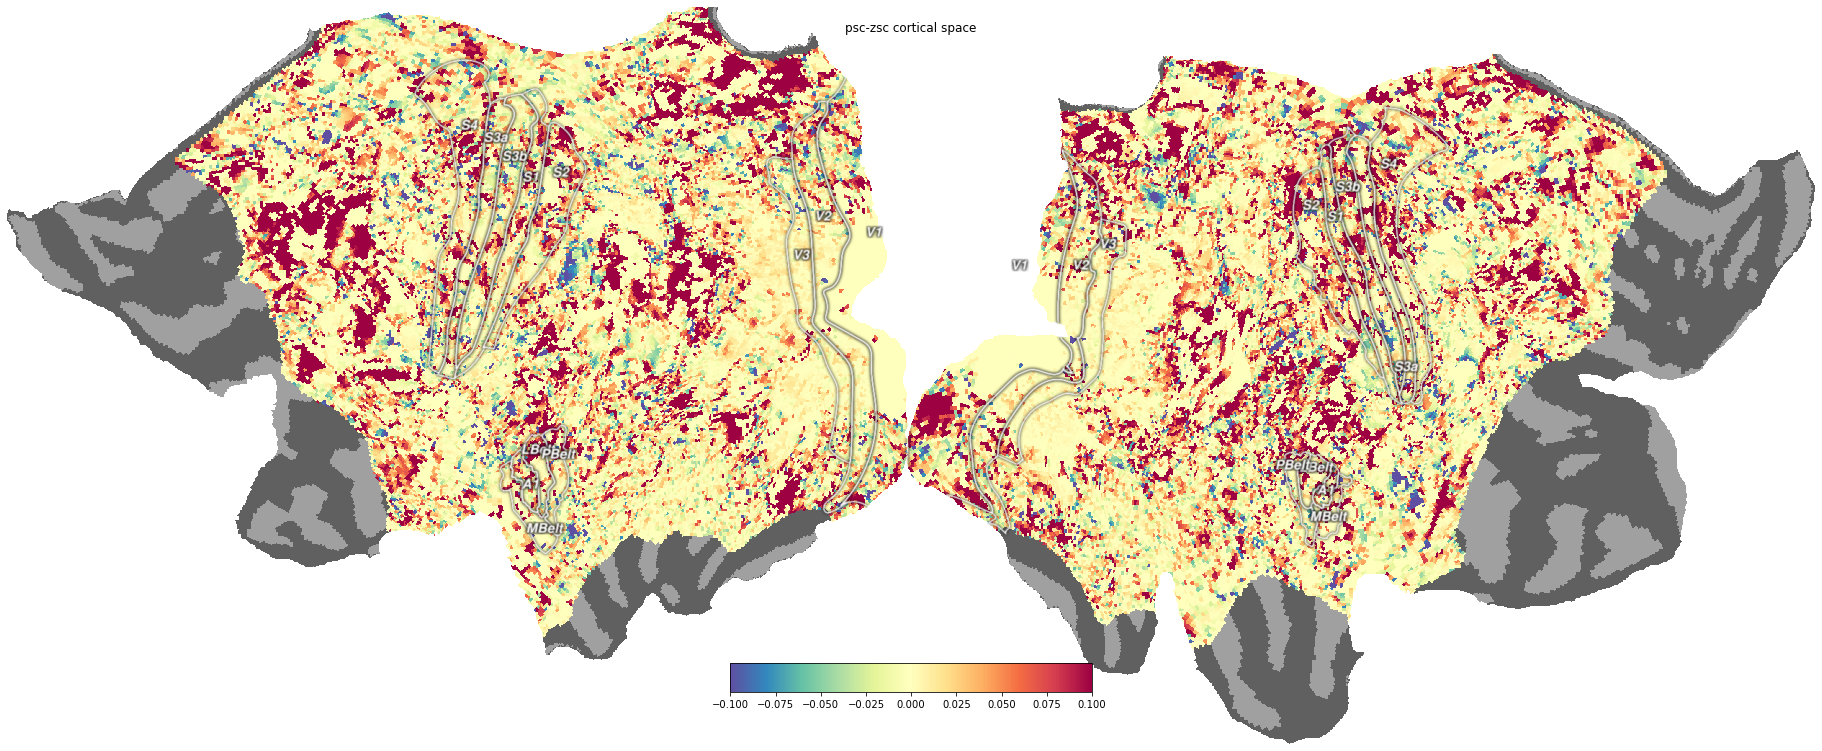

In [202]:
f = cortex.quickshow(cortex.Vertex(diff1, subject='hcp_999999', cmap='Spectral_r', vmin=-0.10, vmax=0.10), with_curvature=True);
f.suptitle('psc-zsc cortical space')

Text(0.5, 0.98, 'psc-zsc visual space')

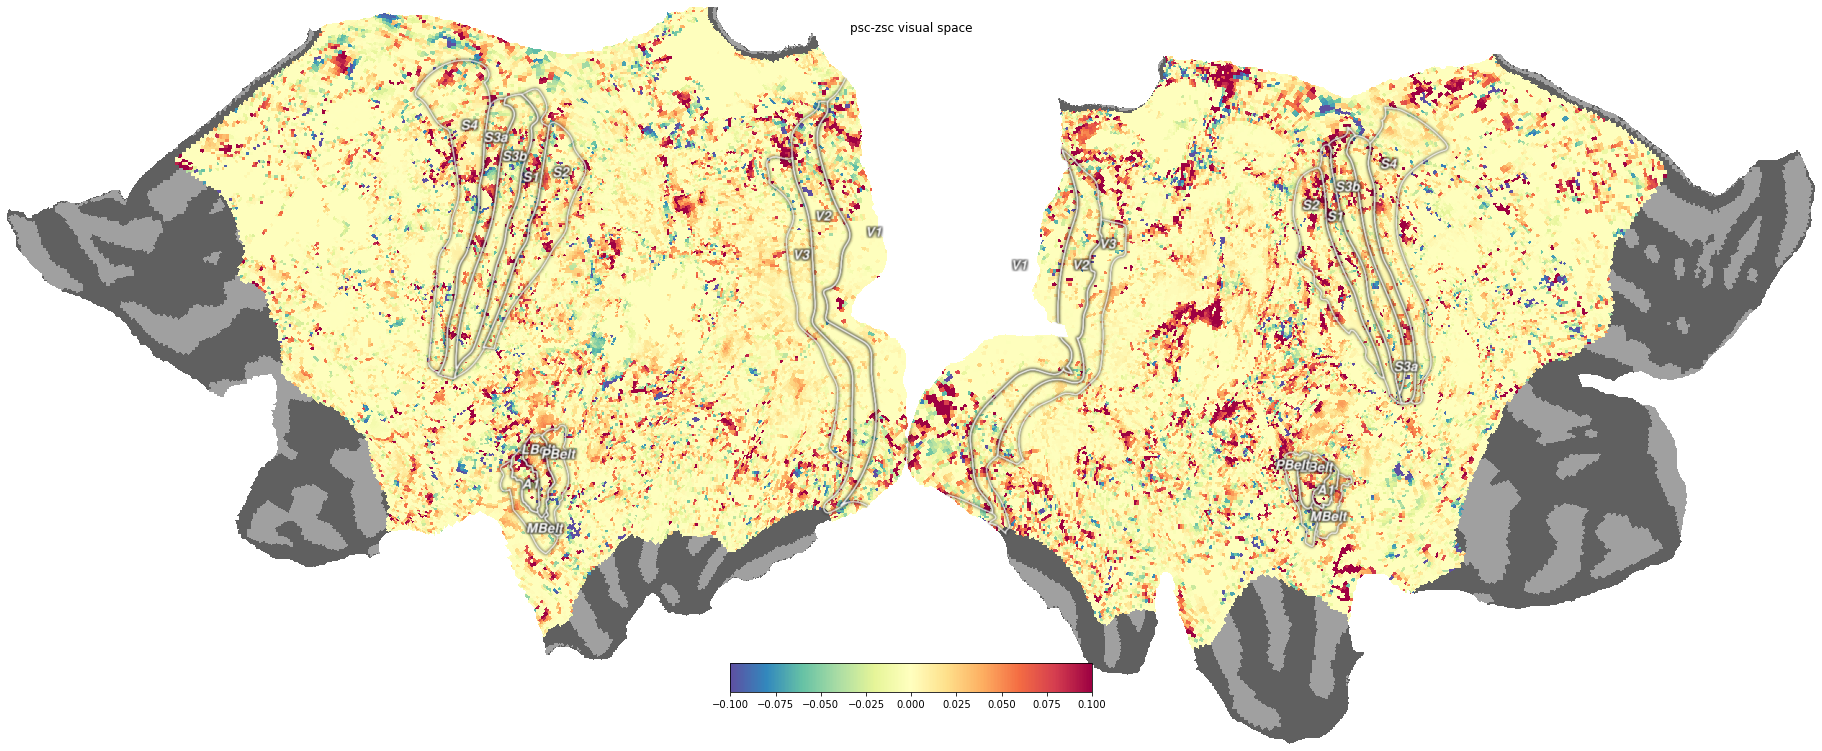

In [203]:
f = cortex.quickshow(cortex.Vertex(diff2, subject='hcp_999999', cmap='Spectral_r', vmin=-0.10, vmax=0.10), with_curvature=True);
f.suptitle('psc-zsc visual space')

Text(0.5, 0.98, 'CV Rsq cortical - visual space fit')

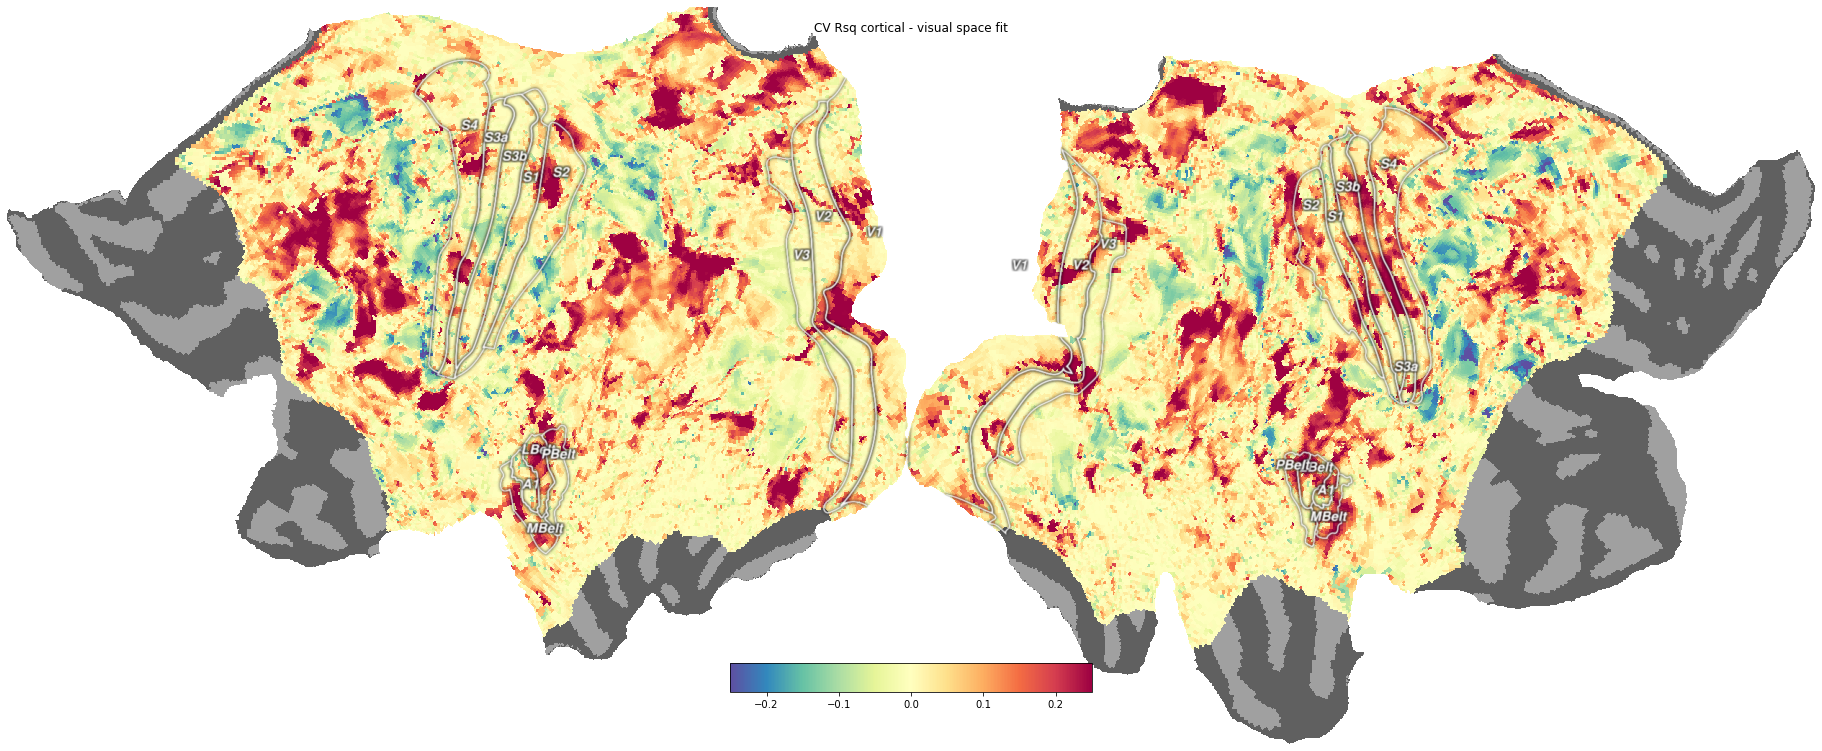

In [181]:
diff = gf.xval_R2-gf_vis.xval_R2
f = cortex.quickshow(cortex.Vertex(diff, subject='hcp_999999', cmap='Spectral_r', vmin=-0.25, vmax=0.25), with_curvature=True);
f.suptitle('CV Rsq cortical - visual space fit S2')

# Actual grid fit and iterative fit of both models

In [149]:
sub = 1
fold = 1

s2_f = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")  

In [150]:
if fold == 1:
    mydat_train = np.nan_to_num(get_cortex(s2_f)[:,10:])
    mydat_test = np.nan_to_num(get_cortex(s2_f2)[:,10:])
    print("fold 1")
elif fold ==2:
    mydat_train = np.nan_to_num(get_cortex(s2_f2)[:,10:])
    mydat_test = np.nan_to_num(get_cortex(s2_f)[:,10:])
    print("fold 2")
else:
    print("there are only 2 folds..")

fold 1


In [151]:
roi_verts = cortex.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [154]:
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])

# create eccentricity mask and combine with Rsq and V1 mask

eccMask = gfn_ecc < max_ecc_size
maskLecc, maskRecc = splitList(eccMask)

Rsqmask = prf_params[:,-1] > 0.4
rsqL, rsqR = splitList(Rsqmask)

V1mask = np.concatenate([maskL, maskR])

maskLecc = maskLecc*rsqL
maskRecc = maskRecc*rsqR
intmask = np.concatenate([maskLecc, maskRecc])
intmask = intmask * V1mask

distmaskL = maskLecc[maskL]
distmaskR = maskRecc[maskR]

# modify the subsurface distances to only include the vertices we want sample from
# and modify the subsurface_verts to correspond to these vertices we want to sample

myv1surf.dists_R = myv1surf.dists_R[distmaskR][:,distmaskR]
myv1surf.dists_L = myv1surf.dists_L[distmaskL][:,distmaskL]
myv1surf.pad_distance_matrices()
myv1surf.subsurface_verts=np.concatenate([myv1surf.subsurface_verts_L[distmaskL],myv1surf.subsurface_verts_R[distmaskR]])

Text(0.5, 0.98, 'V1 vertices that we sample')

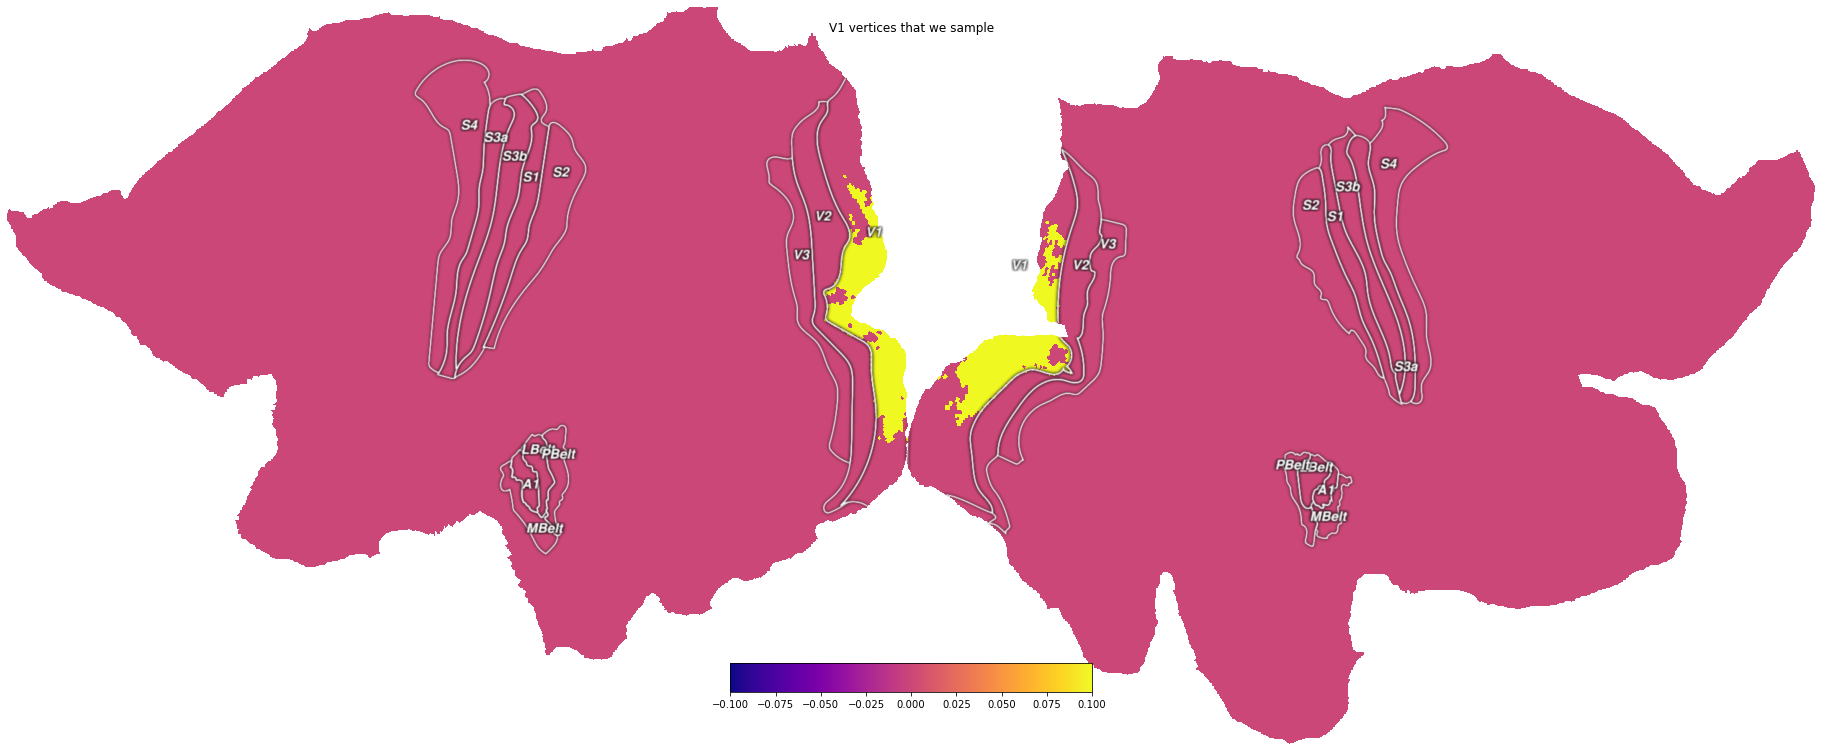

In [155]:
f = cortex.quickshow(cortex.Vertex(intmask.astype(int), subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('V1 vertices that we sample')

In [156]:
# these should be size (N,) and (N, N)
print(myv1surf.subsurface_verts.shape)
print(myv1surf.distance_matrix.shape)

(1177,)
(1177, 1177)


In [157]:
# Make stimuli for training and test data
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,myv1surf.distance_matrix)
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,myv1surf.distance_matrix)

# Make a model
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40])

# Define the fitter
gf = CFFitter(data=mydat_train,model=model)
gf.n_jobs = 10
# Perform the fitting.
gf.grid_fit(sigmas, verbose=True, n_batches=60)
vert_centre, sigmas, beta, baseline, brsq = np.copy(gf.gridsearch_params.T)

CF_bounds = [(0.1, 45),  # sigmas
                (0, 1000),  # beta
                (0, 0.0001), # baseline
                (0, 0)] # vert

CF_bounds = np.array(CF_bounds)
CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf.gridsearch_params.shape[0], axis=0)
CF_bounds[:,3,0] = gf.vertex_centres
CF_bounds[:,3,1] = gf.vertex_centres

# rearrange the gridsearch params so they align with what create_prediction expects
gf.gridsearch_params[:,0] = sigmas
gf.gridsearch_params[:,1] = beta
gf.gridsearch_params[:,2] = baseline
gf.gridsearch_params[:,3] = vert_centre

# run iterative fit
gf.iterative_fit(rsq_threshold=0.05, verbose=True, constraints=[], starting_params=gf.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

# get model predictions
fit_stimulus = np.copy(gf.model.stimulus)
gf.model.stimulus = test_stim

sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf.iterative_search_params.T)
model_tc = np.zeros(mydat_train.shape)
i = 0
for i in range(np.size(vert_centrei)):
    model_tc[i,:] = gf.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

gf.model.stimulus = train_stim

# crossvalidate rsq
CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
CV_rsq[CV_rsq <= -1] = np.nan
CV_rsq[CV_rsq >= 1] = np.nan

gf.iterative_search_params[:,-1] = CV_rsq
gf.iterative_search_params[:,3] = vert_centre

np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/coritcal_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_cortical_space_fold{fold}.npy', gf.iterative_search_params)

Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  3.1min finished
/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   20.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   35.7s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   53.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 4030 tasks      | ela

AttributeError: 'CFFitter' object has no attribute 'iteritave_search_params'

Text(0.5, 0.98, 'CV R2 CF cortical space')

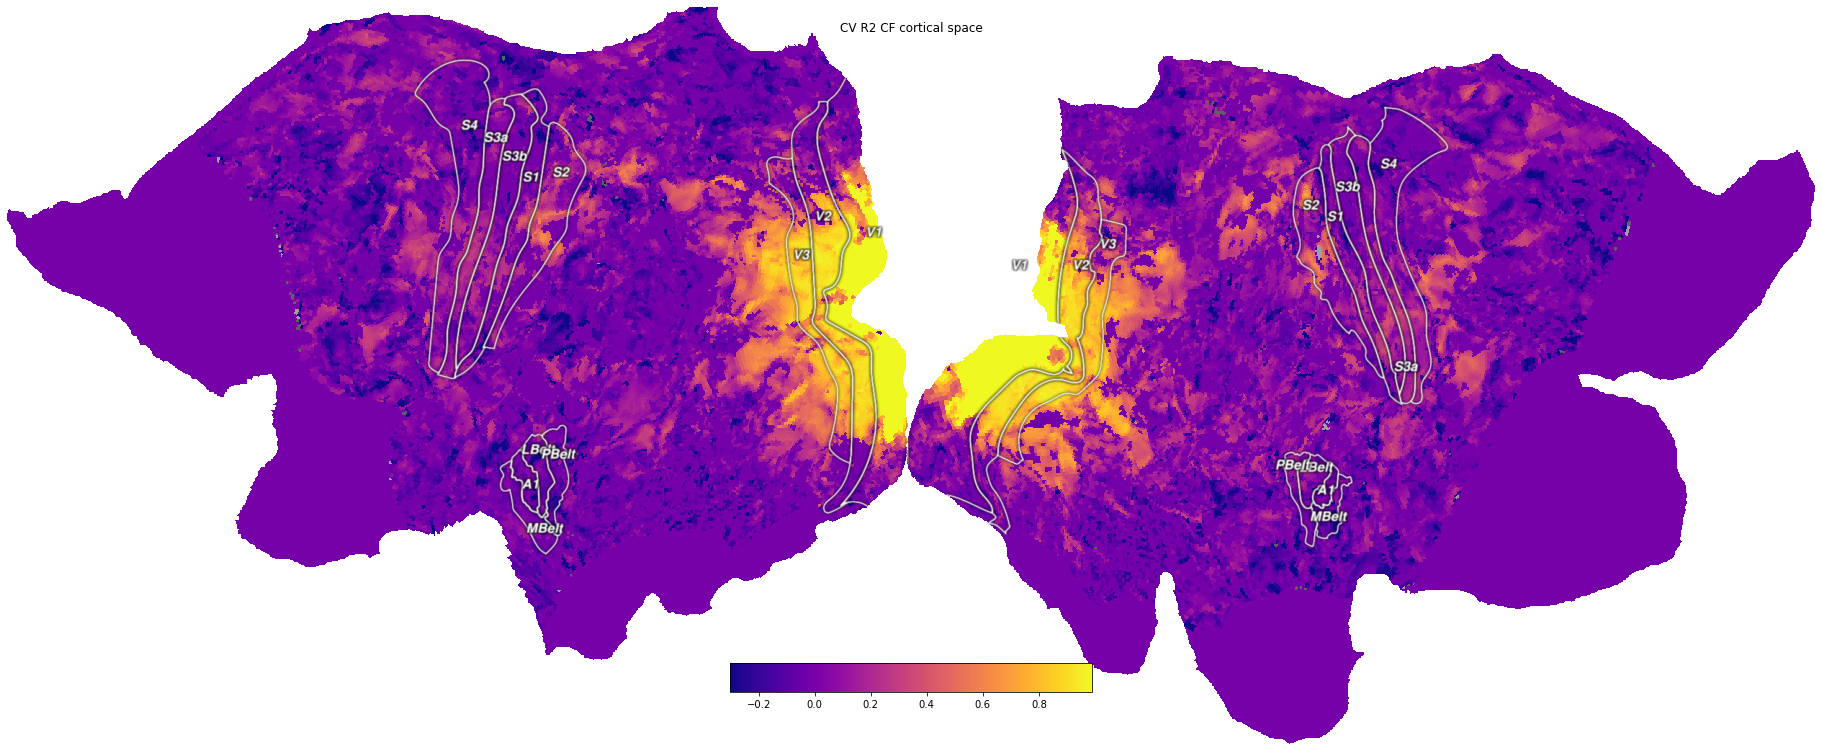

In [160]:
f = cortex.quickshow(cortex.Vertex(gf.iterative_search_params[:,-1], subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('CV R2 CF cortical space')

In [161]:
d2 = {'x': prf_params[:,0], 'y': prf_params[:,1]}
xy_frame = pd.DataFrame(data=d2)

spliced_lookup_xy=xy_frame.iloc[myv1surf.subsurface_verts.astype(int),:]

spliced_lookup_xy

visual_distance_matrix = euclidean_distances(spliced_lookup_xy)
visual_distance_matrix.shape

(1177, 1177)

In [162]:
# Make stimuli for training and test data
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts, visual_distance_matrix)
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts, visual_distance_matrix)

# Make a model
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 10
# Perform the fitting.
gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)
vert_centre, sigmas, beta, baseline, brsq = np.copy(gf_vis.gridsearch_params.T)

CF_bounds = [(0.1, 130),  # sigmas
                (0, 1000),  # beta
                (0, 0.0001), # baseline
                (0, 0)] # vert

CF_bounds = np.array(CF_bounds)
CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
CF_bounds[:,3,0] = gf_vis.vertex_centres
CF_bounds[:,3,1] = gf_vis.vertex_centres

# rearrange the gridsearch params so they align with what create_prediction expects
gf_vis.gridsearch_params[:,0] = sigmas
gf_vis.gridsearch_params[:,1] = beta
gf_vis.gridsearch_params[:,2] = baseline
gf_vis.gridsearch_params[:,3] = vert_centre

# run iterative fit
gf_vis.iterative_fit(rsq_threshold=0.05, verbose=True, constraints=[], starting_params=gf_vis.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

# get model predictions
fit_stimulus = np.copy(gf_vis.model.stimulus)
gf_vis.model.stimulus = test_stim

sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf_vis.iterative_search_params.T)
model_tc = np.zeros(mydat_train.shape)
i = 0
for i in range(np.size(vert_centrei)):
    model_tc[i,:] = gf_vis.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

gf_vis.model.stimulus = train_stim

# crossvalidate rsq
CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
CV_rsq[CV_rsq <= -1] = np.nan
CV_rsq[CV_rsq >= 1] = np.nan

gf_vis.iterative_search_params[:,-1] = CV_rsq
gf_vis.iterative_search_params[:,3] = vert_centre

np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_visual_space_fold{fold}.npy', gf_vis.iterative_search_params)

Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  4.0min finished
/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   18.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   34.0s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   56.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 4030 tasks      | ela

In [ ]:
f = cortex.quickshow(cortex.Vertex(gf_vis.iterative_search_params[:,-1], subject='hcp_999999', cmap='plasma'), with_curvature=True);
f.suptitle('CV R2 CF visual space')

In [ ]:
f = cortex.quickshow(cortex.Vertex(gf.iterative_search_params[:,-1]-gf_vis.iterative_search_params[:,-1], subject='hcp_999999', cmap='Spectral_r', vmin=-0.25, vmax=0.25), with_curvature=True);
f.suptitle('CV R2 CF coritcal - visual space')

# do this with z-scored data

In [164]:
for sub in range(2):
    sub=sub+1
    fold = 1

    s2_f = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy")
    s2_f2 = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full_zsc.npy")  

    if fold == 1:
        mydat_train = np.nan_to_num(get_cortex(s2_f)[:,10:])
        mydat_test = np.nan_to_num(get_cortex(s2_f2)[:,10:])
        print("fold 1")
    elif fold ==2:
        mydat_train = np.nan_to_num(get_cortex(s2_f2)[:,10:])
        mydat_test = np.nan_to_num(get_cortex(s2_f)[:,10:])
        print("fold 2")
    else:
        print("there are only 2 folds..")

    roi_verts = cortex.get_roi_verts('hcp_999999', 'V1',mask=True)

    maskL=roi_verts['V1'][:59292]
    maskR=roi_verts['V1'][59292:]

    myv1surf=subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
    # hyperinflated, superinflated, flat, sphere

    myv1surf.create()

    prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
    gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])

    # create eccentricity mask and combine with Rsq and V1 mask

    eccMask = gfn_ecc < max_ecc_size
    maskLecc, maskRecc = splitList(eccMask)

    Rsqmask = prf_params[:,-1] > 0.4
    rsqL, rsqR = splitList(Rsqmask)

    V1mask = np.concatenate([maskL, maskR])

    maskLecc = maskLecc*rsqL
    maskRecc = maskRecc*rsqR
    intmask = np.concatenate([maskLecc, maskRecc])
    intmask = intmask * V1mask

    distmaskL = maskLecc[maskL]
    distmaskR = maskRecc[maskR]

    # modify the subsurface distances to only include the vertices we want sample from
    # and modify the subsurface_verts to correspond to these vertices we want to sample

    myv1surf.dists_R = myv1surf.dists_R[distmaskR][:,distmaskR]
    myv1surf.dists_L = myv1surf.dists_L[distmaskL][:,distmaskL]
    myv1surf.pad_distance_matrices()
    myv1surf.subsurface_verts=np.concatenate([myv1surf.subsurface_verts_L[distmaskL],myv1surf.subsurface_verts_R[distmaskR]])

#     f = cortex.quickshow(cortex.Vertex(intmask.astype(int), subject='hcp_999999', cmap='plasma'), with_curvature=True);
#     f.suptitle('V1 vertices that we sample')

    # these should be size (N,) and (N, N)
    print(myv1surf.subsurface_verts.shape)
    print(myv1surf.distance_matrix.shape)

    # Make stimuli for training and test data
    train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,myv1surf.distance_matrix)
    test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,myv1surf.distance_matrix)

    # Make a model
    model=CFGaussianModel(train_stim)

    # Define sigmas
    sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40])

    # Define the fitter
    gf = CFFitter(data=mydat_train,model=model)
    gf.n_jobs = 10
    # Perform the fitting.
    gf.grid_fit(sigmas, verbose=True, n_batches=60)
    vert_centre, sigmas, beta, baseline, brsq = np.copy(gf.gridsearch_params.T)

    CF_bounds = [(0.1, 45),  # sigmas
                    (0, 1000),  # beta
                    (0, 0.0001), # baseline
                    (0, 0)] # vert

    CF_bounds = np.array(CF_bounds)
    CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf.gridsearch_params.shape[0], axis=0)
    CF_bounds[:,3,0] = gf.vertex_centres
    CF_bounds[:,3,1] = gf.vertex_centres

    # rearrange the gridsearch params so they align with what create_prediction expects
    gf.gridsearch_params[:,0] = sigmas
    gf.gridsearch_params[:,1] = beta
    gf.gridsearch_params[:,2] = baseline
    gf.gridsearch_params[:,3] = vert_centre

    # run iterative fit
    gf.iterative_fit(rsq_threshold=0.05, verbose=True, constraints=[], starting_params=gf.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

    # get model predictions
    fit_stimulus = np.copy(gf.model.stimulus)
    gf.model.stimulus = test_stim

    sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf.iterative_search_params.T)
    model_tc = np.zeros(mydat_train.shape)
    i = 0
    for i in range(np.size(vert_centrei)):
        model_tc[i,:] = gf.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

    gf.model.stimulus = train_stim

    # crossvalidate rsq
    CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
    CV_rsq[CV_rsq <= -1] = np.nan
    CV_rsq[CV_rsq >= 1] = np.nan

    gf.iterative_search_params[:,-1] = CV_rsq
    gf.iterative_search_params[:,3] = vert_centre


    np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/cortical_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_cortical_space_fold{fold}_zsc.npy', gf.iterative_search_params)


#     f = cortex.quickshow(cortex.Vertex(gf.iterative_search_params[:,-1], subject='hcp_999999', cmap='plasma'), with_curvature=True);
#     f.suptitle('CV R2 CF cortical space')

    d2 = {'x': prf_params[:,0], 'y': prf_params[:,1]}
    xy_frame = pd.DataFrame(data=d2)

    spliced_lookup_xy=xy_frame.iloc[myv1surf.subsurface_verts.astype(int),:]

    spliced_lookup_xy

    visual_distance_matrix = euclidean_distances(spliced_lookup_xy)
    visual_distance_matrix.shape

    # Make stimuli for training and test data
    train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts, visual_distance_matrix)
    test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts, visual_distance_matrix)

    # Make a model
    model=CFGaussianModel(train_stim)

    # Define sigmas
    sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

    # Define the fitter
    gf_vis = CFFitter(data=mydat_train,model=model)
    gf_vis.n_jobs = 10
    # Perform the fitting.
    gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)
    vert_centre, sigmas, beta, baseline, brsq = np.copy(gf_vis.gridsearch_params.T)

    CF_bounds = [(0.1, 130),  # sigmas
                    (0, 1000),  # beta
                    (0, 0.0001), # baseline
                    (0, 0)] # vert

    CF_bounds = np.array(CF_bounds)
    CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
    CF_bounds[:,3,0] = gf_vis.vertex_centres
    CF_bounds[:,3,1] = gf_vis.vertex_centres

    # rearrange the gridsearch params so they align with what create_prediction expects
    gf_vis.gridsearch_params[:,0] = sigmas
    gf_vis.gridsearch_params[:,1] = beta
    gf_vis.gridsearch_params[:,2] = baseline
    gf_vis.gridsearch_params[:,3] = vert_centre

    # run iterative fit
    gf_vis.iterative_fit(rsq_threshold=0.05, verbose=True, constraints=[], starting_params=gf_vis.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

    # get model predictions
    fit_stimulus = np.copy(gf_vis.model.stimulus)
    gf_vis.model.stimulus = test_stim

    sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf_vis.iterative_search_params.T)
    model_tc = np.zeros(mydat_train.shape)
    i = 0
    for i in range(np.size(vert_centrei)):
        model_tc[i,:] = gf_vis.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

    gf_vis.model.stimulus = train_stim

    # crossvalidate rsq
    CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
    CV_rsq[CV_rsq <= -1] = np.nan
    CV_rsq[CV_rsq >= 1] = np.nan

    gf_vis.iterative_search_params[:,-1] = CV_rsq
    gf_vis.iterative_search_params[:,3] = vert_centre

    np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_visual_space_fold{fold}_zsc.npy', gf_vis.iterative_search_params)

#     f = cortex.quickshow(cortex.Vertex(gf_vis.iterative_search_params[:,-1], subject='hcp_999999', cmap='plasma'), with_curvature=True);
#     f.suptitle('CV R2 CF visual space')

#     f = cortex.quickshow(cortex.Vertex(gf.iterative_search_params[:,-1]-gf_vis.iterative_search_params[:,-1], subject='hcp_999999', cmap='Spectral_r', vmin=-0.25, vmax=0.25), with_curvature=True);
#     f.suptitle('CV R2 CF coritcal - visual space')

fold 1
Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


(1177,)
(1177, 1177)
Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  3.1min finished
/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   17.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   49.1s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 4030 tasks      | ela

Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  3.8min finished
/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   17.6s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   32.4s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   56.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | ela

fold 1
Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


(933,)
(933, 933)
Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  1.7min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   26.4s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   43.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: D

Each batch contains approx. 1977 voxels.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  2.3min finished
/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   30.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   49.0s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | ela

In [5]:
s2_f_zsc = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy")
s2_f2_zsc = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full_zsc.npy")  

In [6]:
s2_f = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")  